1. 데이터를 class별로 다른 폴더에 저장
<br> --> 그래야지 클래스별로 몇개씩인지 등 알기 쉬움
2. oversampling한 다음에 1처럼

In [1]:
# TODO 26만 전용으로 구분해주는걸 만들기

---

In [1]:
!rm -r "data/0203_3"

In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
from multiprocessing.dummy import Pool
import math

import numpy as np
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
import random
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter

---

# 1. 데이터를 class별로 다른 폴더에 저장

In [4]:
CUT_RATIO = 2

In [5]:
data = np.load("data/0203.npz")

In [6]:
X_train, Y_train, X_test = data["X_train"], data["Y_train"], data["X_test"]

In [7]:
out_dir = Path("data/0203_3")
out_dir.mkdir(parents=True, exist_ok=True)

train_dir = out_dir / "train"
test_dir = out_dir / "test"
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

In [8]:
def replicate_padding(x):
    r = x[:, 300:]
    l = x[:, :300]
    return np.concatenate([r, x, l], axis=1)

In [9]:
X_train_ = []
for x in X_train:
    X_train_.append(replicate_padding(x))
X_train = np.stack(X_train_)

X_test_ = []
for x in X_test:
    X_test_.append(replicate_padding(x))
X_test = np.stack(X_test_)

In [10]:
nums_per_label = {}
with tqdm(total=len(X_train), ncols=100) as t:
    for i, (x, y) in enumerate(zip(X_train, Y_train)):
        y_ = int(y)

        if y == 26 and random.random() > 1 / CUT_RATIO:
            t.update()
            continue

        if y_ not in nums_per_label:
            nums_per_label[y_] = 0
            (train_dir / f"{y_:02d}").mkdir(exist_ok=True)

        fpath = train_dir / f"{y_:02d}" / f"{i:05d}.npz"
        np.savez_compressed(fpath, x=x, y=y)

        nums_per_label[y_] += 1
        t.update()

100%|██████████████████████████████████████████████████████████| 3125/3125 [00:09<00:00, 336.54it/s]


In [11]:
with tqdm(total=len(X_test), ncols=100) as t:
    for i, x in enumerate(X_test):
        fpath = test_dir / f"{i:05d}.npz"
        np.savez_compressed(fpath, x=x)
        t.update()

100%|████████████████████████████████████████████████████████████| 782/782 [00:02<00:00, 267.05it/s]


# 2. oversampling한 다음에 1처럼

In [12]:
aug_dir = out_dir / "train_aug"
aug_dir.mkdir(parents=True, exist_ok=True)

In [13]:
for i in range(61):
    (aug_dir / f"{i:02d}").mkdir(parents=True, exist_ok=True)

In [14]:
def random_shift(x):
    shift = random.randint(0, 600)
    return np.roll(x, shift, axis=1)


def random_amplitude(x):
    amplitude = random.random() * 0.4 + 0.8
    return x * amplitude


def random_sin(x):
    freqs = [100, 150, 200, 300, 600, 1200]
    wave = np.sin(np.array(list(range(1200))) / random.sample(freqs, 1)[0] * np.pi)
    amplitude = random.random() * 0.3
    signal = 1 + wave * amplitude
    return x * signal.reshape(1, -1)


def random_cos(x):
    freqs = [100, 150, 200, 300, 600, 1200]
    wave = np.cos(np.array(list(range(1200))) / random.sample(freqs, 1)[0] * np.pi)
    amplitude = random.random() * 0.3
    signal = 1 + wave * amplitude
    return x * signal.reshape(1, -1)


def random_blur(x):
    sigma = random.random() * 0.5
    return gaussian_filter(x, sigma=sigma)


def omnirandom(x):
    x = random_shift(x)
    x = random_sin(x)
    x = random_cos(x)
    # x = random_amplitude(x)
    x = random_blur(x)
    return x

In [15]:
# TODO: 많은 것도 2배정도 늘려주고, 나머지도 그만큼 늘려주자

In [16]:
n_max = 1518 / CUT_RATIO
repeat_per_label = {}
for label, n in nums_per_label.items():
    repeat_per_label[label] = round((n_max - n) / n)

In [17]:
items = []
for i, (x, y) in enumerate(zip(X_train, Y_train)):
    y_ = int(y)
    for j in range(repeat_per_label[y_]):
        fpath = aug_dir / f"{y_:02d}" / f"{i:05d}_{j:04d}.npz"
        items.append((i, fpath))


def _f(args):
    i = args[0]
    x = X_train[i]
    y = Y_train[i]
    fpath = args[1]
    x_ = omnirandom(x)
    np.savez_compressed(fpath, x=x_, y=y)

In [18]:
with Pool() as pool:
    with tqdm(total=len(items), ncols=100) as t:
        for _ in pool.imap_unordered(_f, items, chunksize=5):
            t.update()

100%|███████████████████████████████████████████████████████| 44018/44018 [00:41<00:00, 1049.59it/s]


```
data/0203
  - test
    - 00000.npz
    - ...
  - train
    - 00
    - 01
      - 00001.npz
    - ...
  - train_aug
    - 00
    - 01
      - 00002_0001.npz
      - ...
    - ...
```

test와 train 폴더는 원본 데이터  
train_aug는 augmentation된 데이터를 모아둠

## 어떻게 됐나 데이터 확인

In [19]:
!du -sh "data/0203_3"

6.5G	data/0203_3


In [20]:
files = list(aug_dir.rglob("*.npz"))

data/0203_3/train_aug/01/01396_0027.npz
1


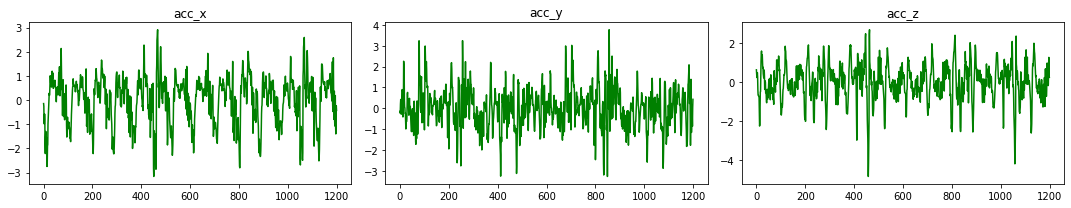

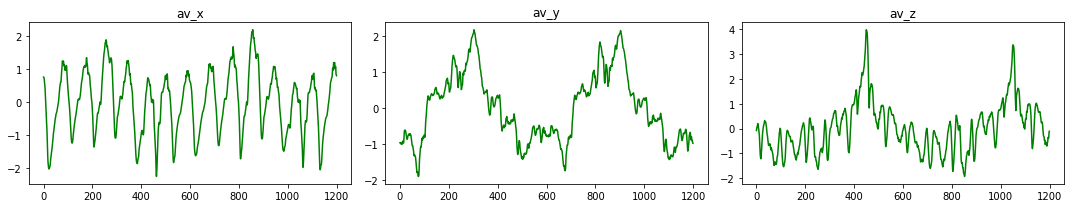

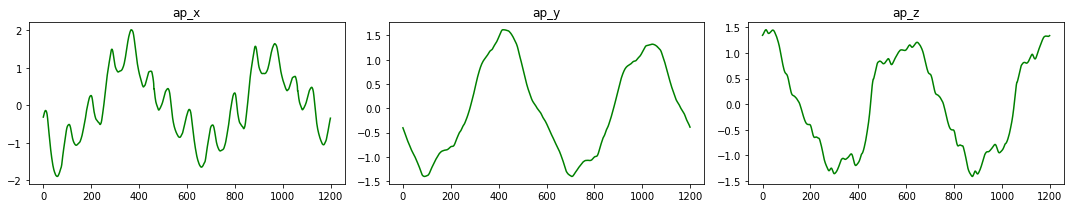

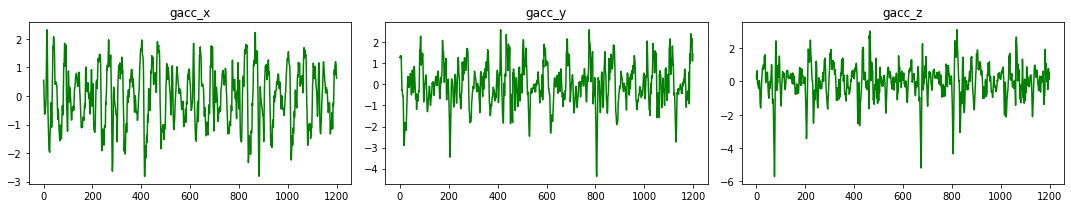

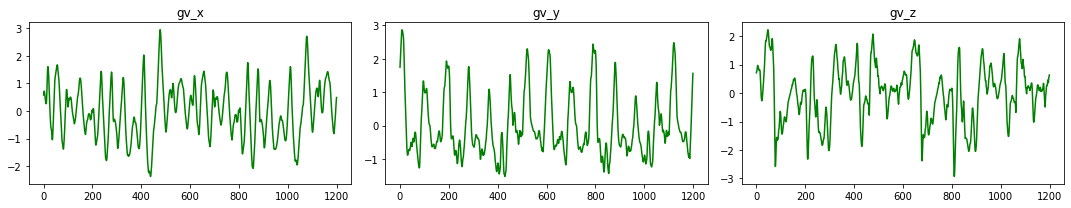

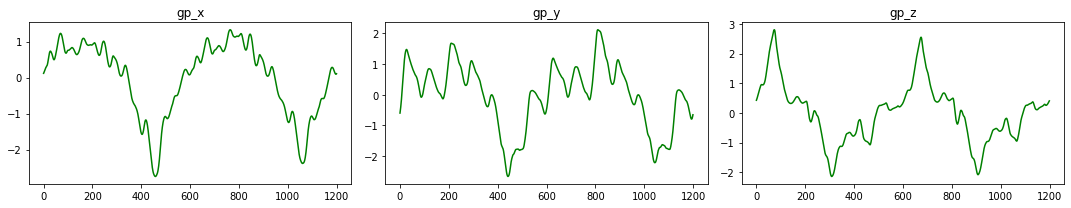

In [21]:
fpath = random.sample(files, 1)[0]
print(fpath)
data = np.load(fpath)
x, y = data["x"], data["y"]
print(y)
titles = ["acc", "gacc", "av", "gv", "ap", "gp"]
suffix = ["x", "y", "z"]

for i in [0, 2, 4, 1, 3, 5]:
    plt.figure(figsize=(15, 3))
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        plt.plot(x[i * 3 + j], "g-")
        plt.title(titles[i] + "_" + suffix[j])
    plt.tight_layout()
    plt.show()

## 각 class별 개수 확인

In [22]:
l = [
    len(list((aug_dir / f"{i:02d}").glob("*.npz"))) + nums_per_label[i]
    for i in range(61)
]

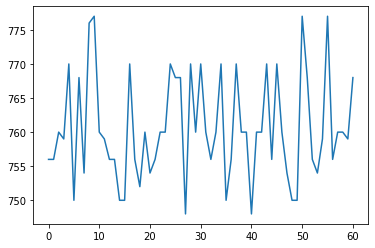

In [23]:
plt.plot(l)